#MLP-MNIST

In [0]:
from __future__ import print_function
import numpy as np ## For numerical python
import keras
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

from tqdm import trange
np.random.seed(42)

A classe Layer funciona como base para as outras camadas que a herdam. Portanto, todas as camadas devem ter: 
* função de forward
* função de backward
* construtor
Nesse caso, como se trata de uma classe "molde" para as outras, a função forward não faz nada

In [0]:
class Layer:
    
    def __init__(self):
        pass
    
    def forward(self, input):
        return input

    def backward(self, input, grad_output):
        return input

## Classe ReLU

Essa classe tem o objetivo de aplica não linearidade nos resultados da rede. Da maneira como fizemos, depois de cada camada Dense existe uma camada ReLU, dessa forma conseguimos classificar coisas não lineares usando uma rede de perceptrons.

In [0]:
class ReLU(Layer):
    
    def __init__(self):
        pass
    
    def forward(self, input):
        relu_forward = np.maximum(0,input)
        return relu_forward
    
    def backward(self, input, grad_output):
        relu_grad = input > 0
        return grad_output*relu_grad


## Classe Dense

Essa classe é a camada de perceptrons comuns que possui os pesos, os bias e o alfa (taxa de aprendizado) dessa rede. 
Na sua função de forward,  as entradas são multiplicadas com as saídas e depois somadas com os bias.
Na função de backward são calculados os erros e a taxa de corração, então os pesos dessa camada são corrigidos.

In [0]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        
        self.learning_rate = learning_rate
        self.weights = np.random.normal(loc=0.0, 
                                        scale = np.sqrt(2/(input_units+output_units)), 
                                        size = (input_units,output_units))
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        # Perform an affine transformation:
        # f(x) = <W*x> + b
        
        # input shape: [batch, input_units]
        # output shape: [batch, output units]
        
        return np.dot(input,self.weights) + self.biases
    
    def backward(self,input,grad_output):
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = np.dot(grad_output, self.weights.T)
        
        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(input.T, grad_output)
        grad_biases = grad_output.mean(axis=0)*input.shape[0]
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
        # Here we perform a stochastic gradient descent step. 
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

## Funções auxiliares


In [0]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

In [0]:
def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

    # normalize x
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.

    # As últimas 1000 entradas são reservadas para validação 
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])

    return X_train, y_train, X_val, y_val, X_test, y_test

In [0]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

## Função forward

Percorre todas as camadas da rede fazer o forward. A saída de uma camada vai para a entrada de outra.
Retorna uma lista com os valores de ativação de cada camada.

In [0]:
def forward(network, X):

    activations = []
    input = X

    # Looping through each layer
    for l in network:
        activations.append(l.forward(input))
        # Updating input to last layer output
        input = activations[-1]
    
    assert len(activations) == len(network)
    return activations

## Função predict

Faz o forward na rede, analisa o valor da saída da última camada e retorna qual o número tem maior probabilidade de estar na imagem de acordo com o aprendizado da rede.

In [0]:
def predict(network,X):
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)

## Função train

Realiza o treino da rede, fazendo o forward em todas as camadas, depois calculando o erro e propagando-o de trás pra frente (backpropagation).

In [0]:
def train(network,X,y):

    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations
    logits = layer_activations[-1]
    
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    for layer_index in range(len(network))[::-1]:
        layer = network[layer_index]
        
        loss_grad = layer.backward(layer_inputs[layer_index],loss_grad) #grad w.r.t. input, also weight updates
        
    return np.mean(loss)

## MAIN

Primeiro vamos mostrar um exemplo de como é o dataset mnist que estamos trabalhando.

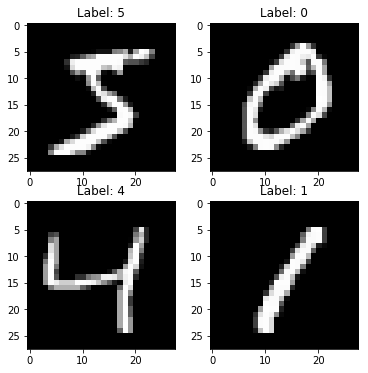

In [35]:
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

network = []
network.append(Dense(X_train.shape[1],100))
network.append(ReLU())
network.append(Dense(100,200))
network.append(ReLU())
network.append(Dense(200,10))

Realizamos um treinamento de 25 épocas.

Epoch 6
Epoch Loss: 0.03781242025581539
Train accuracy: 0.99088
Val accuracy: 0.9765


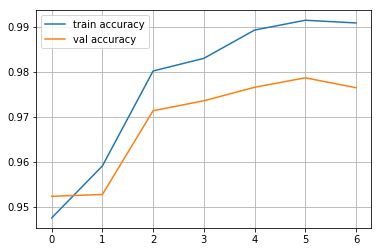

 97%|█████████▋| 1522/1562 [00:04<00:00, 377.43it/s]

In [0]:
from IPython.display import clear_output
train_log = []
val_log = []

for epoch in range(25):
    losses = []
    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        l = train(network,x_batch,y_batch)
        losses.append(l)
        
    losses = np.array(losses)
    epoch_loss = np.mean(losses)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
    clear_output()
    
    print("Epoch",epoch)
    print("Epoch Loss:", epoch_loss)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

Testando 10 instâncias para visualização:

In [0]:
test_log = []
plt.figure(figsize=[6,6])
for i in range(10):
    plt.subplot(4,3,i+1)
    plt.title("Label: %i"%i)
    plt.imshow(X_test[i].reshape([28,28]),cmap='gray');
    print("Predição:",predict(network,X_test[i]),"Resultado esperado:", y_test[i])
    test_log.append(predict(network,X_test[i])==y_test[i])
    
print('accuracy:',np.mean(test_log))
#     print("Test accuracy:",test_log[-1])
#     plt.plot(test_log,label='test accuracy')
#     plt.grid()
#     plt.show()

Heatmap mostrando os resultados obtidos. As colunas representam o palpite que a rede deu para aquele valor.
Os valores que estão na diagonal principal da matriz são, portanto, os acertos que a rede obteve.

In [0]:
test_log = []
predicts = []
for i in range(len(y_test)):
    p = predict(network,X_test[i])
    r = y_test[i]
    predicts.append(p)
    test_log.append(p == r)
    
print('accuracy:',np.mean(test_log))

cm = confusion_matrix(predicts, y_test)

df_cm = pd.DataFrame(cm, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)